# Statistical translation with EM algorithm

## Imports

In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from scipy.special import softmax
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os
import glob
#from time import time

%matplotlib inline
%load_ext autoreload

In [ ]:
%autoreload 2

from process_xml import *
from alignment_metrics import *
from em_models import *

## Download files

In [ ]:
! wget --no-check-certificate --content-disposition https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/homeworks-practice/homework-practice-09-em/L.npy?raw=true
! wget --no-check-certificate --content-disposition https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/homeworks-practice/homework-practice-09-em/y.npy?raw=true

--2021-03-11 12:00:23--  https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/homeworks-practice/homework-practice-09-em/L.npy?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/esokolov/ml-course-hse/raw/master/2020-spring/homeworks-practice/homework-practice-09-em/L.npy [following]
--2021-03-11 12:00:23--  https://github.com/esokolov/ml-course-hse/raw/master/2020-spring/homeworks-practice/homework-practice-09-em/L.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/esokolov/ml-course-hse/master/2020-spring/homeworks-practice/homework-practice-09-em/L.npy [following]
--2021-03-11 12:00:23--  https://raw.githubusercontent.com/esokolov/ml-course-hse/master/2020-spring/homeworks-practice/homework-practice-09-em/L.npy
Resolving ra

# Word Alignment

In [ ]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


## Extracting sentences
 Let's write a function that takes a path to an XML file with alignments and outputs a list of parallel sentences.


In [ ]:
all_sentences = []
all_targets = []

for path, subdirs, files in os.walk('./data/data'):
    for name in files:
        cur_file = os.path.join(path, name)
        cur_sentences, cur_targets = extract_sentences(cur_file)

        all_sentences += cur_sentences
        all_targets += cur_targets

len(all_sentences)

5002

## Tokenization
 Now let's tokenize the words.

In [ ]:
t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

In [ ]:
baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

## Metrics
 We will need specific scoring functions to measure the effectiveness of our models. Let's use AER (Alignment Error Rate)

In [ ]:
compute_aer(all_targets, baseline.align(tokenized_sentences))

0.8135630370634345

AER score examples:

![](https://www.researchgate.net/profile/Hermann-Ney/publication/2807338/figure/tbl1/AS:669566984265759@1536648617935/Alignment-error-rate-AER-of-ditlrent-alignment-models-tbr-the-translations.png)

https://www.researchgate.net/figure/Alignment-error-rate-AER-of-ditlrent-alignment-models-tbr-the-translations_tbl1_2807338

## EM equations


Sources:


1.   http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.421.5497&rep=rep1&type=pdf
2.   https://www.cs.jhu.edu/~jason/665/PowerPoint/lect32a-mt-word-based-models.pdf
3.   http://www.cs.cmu.edu/afs/cs/user/tbergkir/www/11711fa17/recitation10_slides.pdf
4.   http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.421.5497&rep=rep1&type=pdf
5.   https://www.kaggle.com/garbo999/machine-translation-ibm-model-1-em-algorithm



**E-step:**
$$ 
p(A | T, S, \theta) = \frac{p(T, A | S, \theta)}{p(T | S, \theta)} = \prod_{i=1}^m \frac{p(t_i, a_i | S, \theta)}{p(t_i | S, \theta)}
$$

$$
p(a_i | T, S, \theta) = \frac{p(t_i, a_i | S, \theta)}{p(t_i | S, \theta)}
=  \frac{p(a_i)\theta(t_i | s_{a_i})}{\sum_{j=1}^{n} p(a_j)\theta(t_i | s_{a_j})}
$$

$$
q_{t_k, s_p}^* = \sum_{t_i, s_j \in T, S} [t_i = t_k][s_j=s_p][a_i=j]p(a_i | T, S, \theta)
$$

$$
q_{t_k, s_p}^* = \frac{\theta(t_k|s_p)}{\sum_{s_i \in S} \theta(t_k|s_i)}
$$


**M-step:**
$$
\ln p(A, T | S) = \sum_{t_i \in T} \ln \theta(t_i, s_j) - \ln n
$$
$$
E \ln p(A, T | S) = \sum_{s_j \in S} \frac{\theta(t_i|s_p)}{\sum_{s_p \in S} \theta(t_i|s_p)} \sum_{t_i \in T} \ln \theta(t_i | s_j) - \ln n = \sum_{s_j \in S}  \sum_{t_i \in T} q_{t_i, s_j} (\theta(t_i | s_j) - \ln n)
$$ 


$$
Q = \sum_{s_j \in S}  \sum_{t_i \in T} q^*_{t_i, s_j} (\theta(t_i | s_j) - \ln n) - \sum_{s_j \in S}  \sum_{t_i \in T}  \lambda_{s_j} \theta(t_i | s_j) 
$$

$$
Q' = \sum_{s_j \in S}  \sum_{t_i \in T} \frac{q^*_{t_i, s_j}}{\theta(t_i | s_j) } - \lambda_{s_j},\ \lambda_{s_j} = \sum_{t_i \in T} \frac{q^*_{t_i, s_j}}{\theta(t_i | s_j) } = \sum_{t_i \in T} q^*_{t_i,s_j}
$$

$$
\theta^{new}(t_i, s_j) = \frac{q^*_{t_i,s_j}}{\sum_{t_k \in T} q^*_{t_k,s_j}}
$$

**ELBO:**
$$
\ln p(A, T | S) = \sum_{s_j \in S} \ln \theta(t_i, s_j) - \ln n
$$
Cross entropy:

$$
\text{ELBO} = \sum_{t_j \in T}\sum_{s_j \in S}  q^*_{t_i,s_j} \big[ \ln \frac{\theta(t_i, s_j)}{q^*_{t_i,s_j}} -  \frac{\ln n}{q^*_{t_i,s_j}} \big]
$$
$$
\text{ELBO} = \sum_{t_j \in T}\sum_{s_j \in S}  q^*_{t_i,s_j} \ln \theta(t_i, s_j) - q^*_{t_i,s_j} \ln n - q^*_{t_i,s_j} \ln q^*_{t_i,s_j}
$$

## The algorithm itself
 And now we can finally create a WordAligner class.

In [ ]:
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 10)
hist = word_aligner.fit(tokenized_sentences);

Iter 0, Time elapsed 0.000;
Iter 1, Time elapsed 1.027;
Iter 2, Time elapsed 2.043;
Iter 3, Time elapsed 3.054;
Iter 4, Time elapsed 4.051;
Iter 5, Time elapsed 5.073;
Iter 6, Time elapsed 6.069;
Iter 7, Time elapsed 7.062;
Iter 8, Time elapsed 8.055;
Iter 9, Time elapsed 9.059;


In [ ]:
compute_aer(all_targets, word_aligner.align(tokenized_sentences))

0.5838807543815219

Let's see how our algorithm translates specific words:

In [ ]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

[',', 'řekl', 'pan']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['překupničením', 'koni', 'záviselo']

In [ ]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['se', '.', 'na']

## Visualization
 We can draw a heatmap visualizing how the words are aligned in a specific sentence.

In [ ]:
text = tokenized_sentences[:1]
eng = tokenized_sentences[0].source_tokens
cz = tokenized_sentences[0].target_tokens
alignment = word_aligner.align(text)[0]

matr = np.zeros((len(eng), len(cz)))

for j, k in alignment:
    matr[j - 1][k - 1] = 1

eng = [idx_token_src[i] for i in eng]
cz = [idx_token_tgt[i] for i in cz]

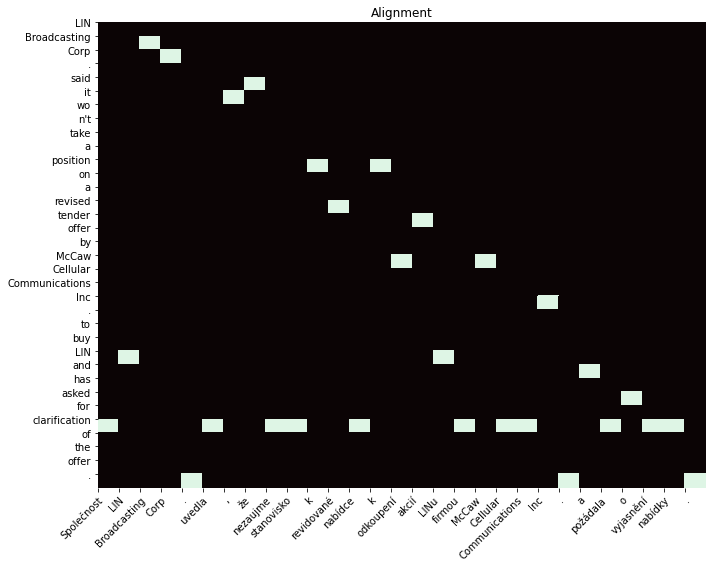

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(matr, cbar=False, cmap='mako')

ax.set_xticks(np.arange(len(cz)))
ax.set_yticks(np.arange(len(eng)))
ax.set_xticklabels(cz)
ax.set_yticklabels(eng)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

ax.set_title("Alignment")
fig.tight_layout()
plt.show()

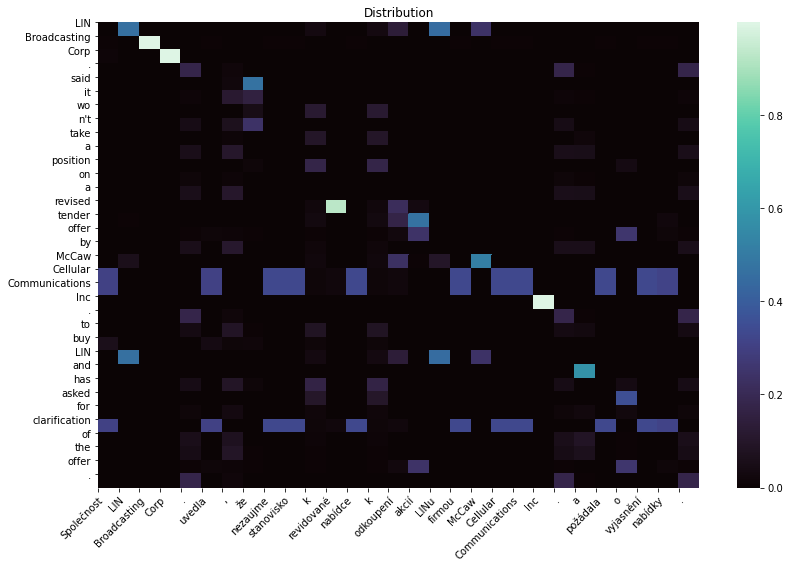

In [ ]:
distr = word_aligner._e_step(text)[0]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(distr, cbar=True, cmap='mako')

ax.set_xticks(np.arange(len(cz)))
ax.set_yticks(np.arange(len(eng)))
ax.set_xticklabels(cz)
ax.set_yticklabels(eng)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

ax.set_title("Distribution")
fig.tight_layout()
plt.show()

The model is most confident in the alignments on the diagonal and at the end of the English sentence (since it is shorter than the Czech one). The algorithm works well with proper nouns. But we can also notice that if a pair of words is often used together, the algorithm will not be sure which one corresponds to which (this can be seen on the heatmap, there are many monotone 2x2 squares).